# 웹 크롤링 실습

In [1]:
# 주제: 이스라엘 전쟁

import requests # 웹 페이지 내용 가져오기
import logging # 로그 메세지 기록 및 관리

import pandas as pd # 데이터 구조화 및 분석을 위한 데이터 프레임 생성
from tqdm import tqdm # 진행 상황을 시각적으로 표시

from bs4 import BeautifulSoup # HTML 문서 파싱 및 원하는 정보 추출

import pickle # 직렬화
import time # 시간 관련 작업에 사용


# _____________________________________________________________________


# 로깅 설정  / logging.basicConfig()함수
# 뉴스 크롤링한 시간 기록

# (1. 경로, 2. 레벨(정보성 메세지), 3. 출력형식)
logging.basicConfig(filename = 'crawler.log', 
                    level = logging.INFO, 
                    format = '%(asctime)s - %(levelname)s - %(message)s')



# 함수로 크롤링 작업 분리
def get_news_urls(query, page):
    
    # 이스라엘 전쟁 1개월 url
    url_template = ("https://search.naver.com/search.naver"
                    "?where=news&query={query}&sm=tab_opt&sort=0&photo=0&field=0&pd=2"
                    "&ds=&de=&docid=&related=0&mynews=0&office_type=0"
                    "&office_section_code=0&news_office_checked=&nso=so:r,p:1m"
                    "&is_sug_officeid=0&office_category=0&service_area=0&start={page}")
    
    # 각각을 매개변수로 받은 값으로 대체
    url = url_template.format(query=query, page=page)
    
    
    # HTTP 요청 헤더: 사용자 에이전트를 설정하여 웹브라우저 처럼 보이도록 함
    # User-Agent: 웹 서버가 요청을 거부하지 못하도록 함 + 봇으로 인식됨을 방지
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"}
    
    # 해당 url에 GET 요청을 보냄
    # 오류를 처리하는 방법 정의: 예외 발생
    response = requests.get(url, headers=headers)
    response.raise_for_status()
    
    
    # 받은 응답 내용: BeautifulSoup으로 파싱 
    soup = BeautifulSoup(response.text, "html.parser")
    urls = [a['href'] for a in soup.select("a.info")]
    
    # 선택된 url 리스트로 반환
    return urls

#_______________________________________________________________


# 뉴스 제목과 내용 관련 함수
def get_news_content(url):
    
    
    try:
        headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"}
        
        # 타임아웃: 대기 시간 제한
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
        
        
        soup = BeautifulSoup(response.text, "html.parser")
        title = soup.select_one(".media_end_head_headline")
        
        
        content = soup.select_one("#dic_area")
        
        
        if title and content:
            return title.text.strip(), content.text.strip()
    
    
    # try에서 발생한 예외 처리: 오류를 로그에 기록
    except requests.exceptions.RequestException as e:
        logging.error(f"Failed to crawl {url}: {e}")
    
    # 1. 예외 발생, 2. 제목&내용 없을 경우: 둘다 None으로 처리
    return None, None


#_________________________________________________________________________



# 크롤링 설정
query = "이스라엘 전쟁"
total_pages = 100 # 스크롤 대신 사용: 임의의 수 100으로 진행



# 크롤링 진행 상태 표시: tqdm 함수
with tqdm(total=total_pages) as pbar:
    news_data = []
    page = 1
    
    while page <= total_pages * 10:
        
        news_urls = get_news_urls(query, page)
        
        if not news_urls:
            break
        
        for news_url in news_urls:
            title, content = get_news_content(news_url)
            
            # 제목과 내용이 둘다 존재할 경우에만
            if title and content:
                news_data.append({"date": time.strftime("%Y-%m-%d %H:%M:%S"), "title": title, "content": content, "url": news_url})
        
        
        page += 10
        pbar.update(1)
        
        if len(news_data) % 10 == 0:
            print(f"진행 상황: {len(news_data)} 개의 뉴스 수집 완료")
        time.sleep(1)  # 서버 부하를 줄이기 위해 잠시 대기

        

# 데이터프레임으로 변환 후 pickle 파일로 저장
df = pd.DataFrame(news_data)
with open("news_data10.pkl", "wb") as f:
    pickle.dump(df, f)

    
# 저장한 pickle 파일 불러오기
with open("news_data10.pkl", "rb") as f:
    loaded_df = pickle.load(f)

    
# CSV로 저장
output_file = "naver_news_war10.csv"
loaded_df.to_csv(output_file, index=False, encoding='utf-8-sig')
logging.info(f"크롤링 완료: {output_file}")

  5%|████                                                                              | 5/100 [02:04<39:46, 25.12s/it]

진행 상황: 40 개의 뉴스 수집 완료


  6%|████▉                                                                             | 6/100 [02:33<41:29, 26.48s/it]

진행 상황: 50 개의 뉴스 수집 완료


 27%|█████████████████████▊                                                           | 27/100 [11:19<28:42, 23.60s/it]

진행 상황: 220 개의 뉴스 수집 완료


 28%|██████████████████████▋                                                          | 28/100 [11:47<29:56, 24.95s/it]

진행 상황: 230 개의 뉴스 수집 완료


 29%|███████████████████████▍                                                         | 29/100 [12:14<30:26, 25.72s/it]

진행 상황: 240 개의 뉴스 수집 완료


 37%|█████████████████████████████▉                                                   | 37/100 [15:43<26:59, 25.70s/it]

진행 상황: 310 개의 뉴스 수집 완료


 38%|██████████████████████████████▊                                                  | 38/100 [16:09<26:34, 25.72s/it]

진행 상황: 320 개의 뉴스 수집 완료


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [29:41<12:30, 25.02s/it]

진행 상황: 590 개의 뉴스 수집 완료


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [32:05<09:31, 23.81s/it]

진행 상황: 640 개의 뉴스 수집 완료


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [36:49<05:37, 25.95s/it]

진행 상황: 730 개의 뉴스 수집 완료


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [40:06<02:00, 24.13s/it]

진행 상황: 790 개의 뉴스 수집 완료


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [42:15<00:00, 25.35s/it]


In [2]:
import pandas as pd
import pickle

# CSV 파일 로드
input_file = r"C:\Users\jkl12\personal activity\naver_news_war10.csv"
df = pd.read_csv(input_file)

# 데이터프레임 출력 (기본 형태)
# print(df.head())

# 긴 문자열을 줄이는 함수 정의
def shorten_text(text, length=20):
    if len(text) > length:
        return text[:length] + '...'
    return text

# 데이터프레임 정리
# 예: 'date', 'title', 'content' 컬럼만 선택하고 'date' 컬럼을 기준으로 정렬
df_cleaned = df[['date', 'title', 'content']].sort_values(by='date')

# 문자열 길이를 줄임
df_cleaned['title'] = df_cleaned['title'].apply(shorten_text)
df_cleaned['content'] = df_cleaned['content'].apply(shorten_text)

# 정리된 데이터프레임 출력
print(df_cleaned.head())
print(df_cleaned.tail())

                  date                    title                  content
0  2024-06-21 20:37:37  이스라엘·헤즈볼라 전면전 우려 고조…...  나스랄라 “새로운 무기 갖게 돼최북단...
1  2024-06-21 20:37:40  분열하는 이스라엘…IDF 대변인 "하...  "하마스는 이념이자 정당"…연정 전쟁...
2  2024-06-21 20:37:42  이스라엘군, 공격계획 승인...헤즈볼...  [앵커]레바논 무장정파 헤즈볼라가 이...
3  2024-06-21 20:37:45  이스라엘, 레바논 공격 승인… 전면전...  헤즈볼라, 이 중심부 공격 위협에“심...
4  2024-06-21 20:37:47  유엔 “이스라엘에 무기 팔아도 전쟁범...  20일(현지시각) 이스라엘방위군(ID...
                    date                    title                  content
821  2024-06-21 21:19:35  국제사법재판소, 이스라엘에 ‘라파 공...  가자전쟁 이후 세 번째 임시명령이스라...
822  2024-06-21 21:19:38  이스라엘 전쟁범죄 조사하던 ICC 검...  가디언 보도 "전직국장 재임때 가족안...
823  2024-06-21 21:19:42  “국제사법재판소, 이스라엘에 ‘라파 ...  유엔 국제사법재판소 ICJ가 현지시각...
824  2024-06-21 21:19:45  유럽 3국, 팔레스타인 국가 공식 인...  스페인·아일랜드·노르웨이"전쟁 끝내려...
825  2024-06-21 21:19:47  미국 최대 흑인단체, 바이든에 “이스...  전미유색인지위향상협회(NAACP) 성...


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jkl12\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


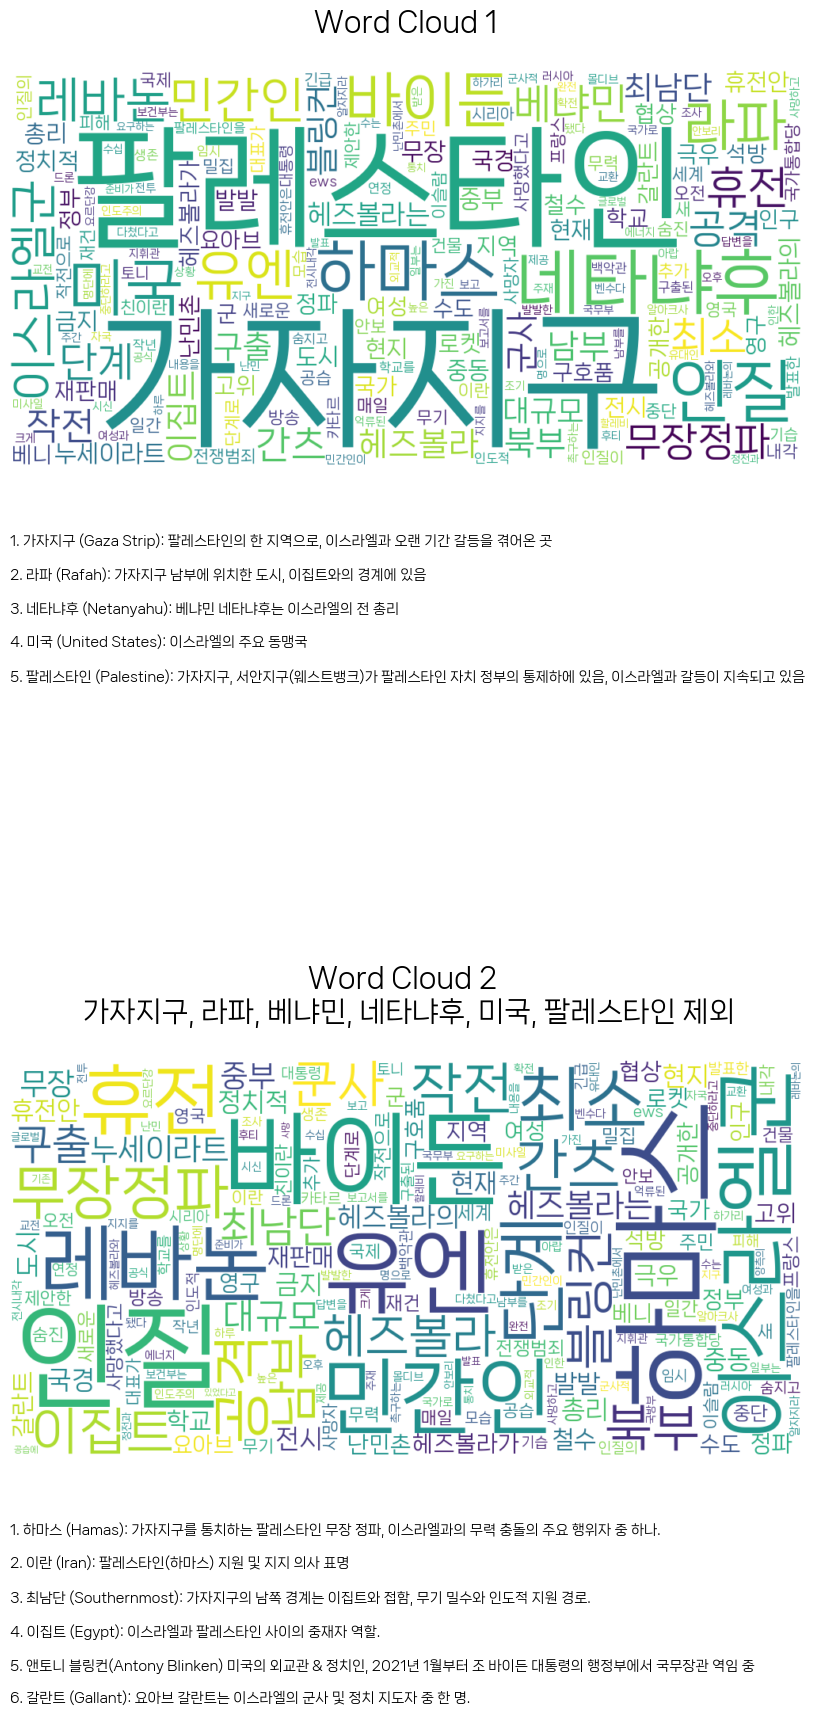

In [4]:
# 워드 클라우드: 이스라엘 전쟁

import re # 정규표현식 사용: 텍스트 데이터를 클렌징
import pandas as pd # 데이터 프레임 사용

import os # 파일의 존재 검사
from collections import Counter # 단어의 빈도수 계산

import nltk # 자연어 처리: 텍스트 토큰화를 위해 사용
from nltk.tokenize import word_tokenize # 텍스트 데이터를 단어 단위로 분할하기

import pickle # pickle 파일 로드

# 워드 클라우드
from wordcloud import WordCloud # 생성
import matplotlib.pyplot as plt # 시각화
from matplotlib import font_manager, rc # 폰트


# ________________________________________________________


# 불용어 사전 파일 경로
stopword_file_path1 = r"C:\Users\jkl12\Downloads\불용어 사전.txt"
stopword_file_path2 = r"C:\Users\jkl12\Downloads\불용어 사전2.txt"


# 불용어 사전 로드 함수
def load_stopwords(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        
        # 줄 단위로 나누기
        stopwords = file.read().splitlines()
    
    # 불용어 리스트를 집합(set)으로 변환하여 중복 제거
    return set(stopwords)

# 불용어 사전 호출 및 변수에 저장
custom_stopwords1 = load_stopwords(stopword_file_path1)
custom_stopwords2 = load_stopwords(stopword_file_path2)


# ___________________________________________________________


# news_data3.pkl 파일 로드
with open("news_data10.pkl", "rb") as f:
    news_data = pickle.load(f)
    
    
# 뉴스 데이터에서 텍스트 추출
text_data = ' '.join(news_data['content'])


# 텍스트 클렌징
def clean_text(text):
    
    # 특수 문자 및 숫자 제거
    text = re.sub(r'[^a-z가-힣\s]', '', text)
    
    return text

# 클렌징된 텍스트 생성
cleaned_text = clean_text(text_data)


# _________________________________________________________



# NLTK 데이터 다운로드 (최초 1회 실행)
# 문장 분리 및 단어 토큰화를 위해 필요한 데이터
nltk.download('punkt')

# 토큰화: 단어 단위로 분할
tokens = word_tokenize(cleaned_text)


# 불용어 사전에 포함된 단어를 제외한 단어들만 남기기
# 빈도수 계산

filtered_tokens1 = [word for word in tokens if word not in custom_stopwords1]
word_counts1 = Counter(filtered_tokens1)

filtered_tokens2 = [word for word in tokens if word not in custom_stopwords2]
word_counts2 = Counter(filtered_tokens2)


# 나눔고딕 폰트 설정
font_path = r"C:\Users\jkl12\OneDrive\바탕 화면\내 파일\기밀문서\자료\내 파일\폰트\nanum-all\나눔 글꼴\나눔스퀘어네오\NanumSquareNeo-bRg.ttf"

# 폰트 설정
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

# 워드 클라우드 생성
wordcloud1 = WordCloud(width=1000, height=500, background_color='white', font_path=font_path).generate_from_frequencies(word_counts1)
wordcloud2 = WordCloud(width=1000, height=500, background_color='white', font_path=font_path).generate_from_frequencies(word_counts2)

# 워드 클라우드 시각화
plt.figure(figsize=(12, 18))

# 첫 번째 워드 클라우드
plt.subplot(2, 1, 1)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.title('Word Cloud 1\n', fontproperties=font_manager.FontProperties(fname=font_path, size=20))
plt.axis('off')
plt.text(0, -0.4, 
         '1. 가자지구 (Gaza Strip): 팔레스타인의 한 지역으로, 이스라엘과 오랜 기간 갈등을 겪어온 곳\n\n'
         '2. 라파 (Rafah): 가자지구 남부에 위치한 도시, 이집트와의 경계에 있음\n\n'
         '3. 네타냐후 (Netanyahu): 베냐민 네타냐후는 이스라엘의 전 총리\n\n' 
         '4. 미국 (United States): 이스라엘의 주요 동맹국\n\n'
         '5. 팔레스타인 (Palestine): 가자지구, 서안지구(웨스트뱅크)가 팔레스타인 자치 정부의 통제하에 있음, 이스라엘과 갈등이 지속되고 있음\n\n',
         ha='left', va='center', 
         transform=plt.gca().transAxes, fontsize=10, fontproperties=font_manager.FontProperties(fname=font_path))


# 두 번째 워드 클라우드
plt.subplot(2, 1, 2)
plt.imshow(wordcloud2, interpolation='bilinear')
plt.title('Word Cloud 2 \n 가자지구, 라파, 베냐민, 네타냐후, 미국, 팔레스타인 제외\n', fontproperties=font_manager.FontProperties(fname=font_path, size=20))
plt.axis('off')
plt.text(0, -0.4, 
         '1. 하마스 (Hamas): 가자지구를 통치하는 팔레스타인 무장 정파, 이스라엘과의 무력 충돌의 주요 행위자 중 하나.\n\n'
         '2. 이란 (Iran): 팔레스타인(하마스) 지원 및 지지 의사 표명 \n\n'
         '3. 최남단 (Southernmost): 가자지구의 남쪽 경계는 이집트와 접함, 무기 밀수와 인도적 지원 경로.\n\n'
         '4. 이집트 (Egypt): 이스라엘과 팔레스타인 사이의 중재자 역할.\n\n'
         '5. 앤토니 블링컨(Antony Blinken) 미국의 외교관 & 정치인, 2021년 1월부터 조 바이든 대통령의 행정부에서 국무장관 역임 중 \n\n'
         '6. 갈란트 (Gallant): 요아브 갈란트는 이스라엘의 군사 및 정치 지도자 중 한 명.',
         ha='left', va='center', 
         transform=plt.gca().transAxes, fontsize=10, fontproperties=font_manager.FontProperties(fname=font_path))



# 두 워드 클라우드 간격 조정
plt.subplots_adjust(hspace=1.5)

plt.show()